LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
Training data shape: X=torch.Size([1590, 10, 1]), y=torch.Size([1590, 1])
Testing data shape: X=torch.Size([390, 10, 1]), y=torch.Size([390, 1])

Training LSTM model ...
Epoch 1/80, Loss: 0.665070
Epoch 2/80, Loss: 0.648336
Epoch 3/80, Loss: 0.632149
Epoch 4/80, Loss: 0.616401
Epoch 5/80, Loss: 0.601004
Epoch 6/80, Loss: 0.585869
Epoch 7/80, Loss: 0.570911
Epoch 8/80, Loss: 0.556052
Epoch 9/80, Loss: 0.541227
Epoch 10/80, Loss: 0.526374
Epoch 11/80, Loss: 0.511437
Epoch 12/80, Loss: 0.496361
Epoch 13/80, Loss: 0.481098
Epoch 14/80, Loss: 0.465600
Epoch 15/80, Loss: 0.449825
Epoch 16/80, Loss: 0.433734
Epoch 17/80, Loss: 0.417297
Epoch 18/80, Loss: 0.400489
Epoch 19/80, Loss: 0.383303
Epoch 20/80, Loss: 0.365745
Epoch 21/80, Loss: 0.347851
Epoch 22/80, Loss: 0.329688
Epoch 23/80, Loss: 0.311378
Epoch 24/80, Loss: 0.293104
Epoch 25/80, Loss: 0.275135
Epoch 26/80, Loss: 0.257

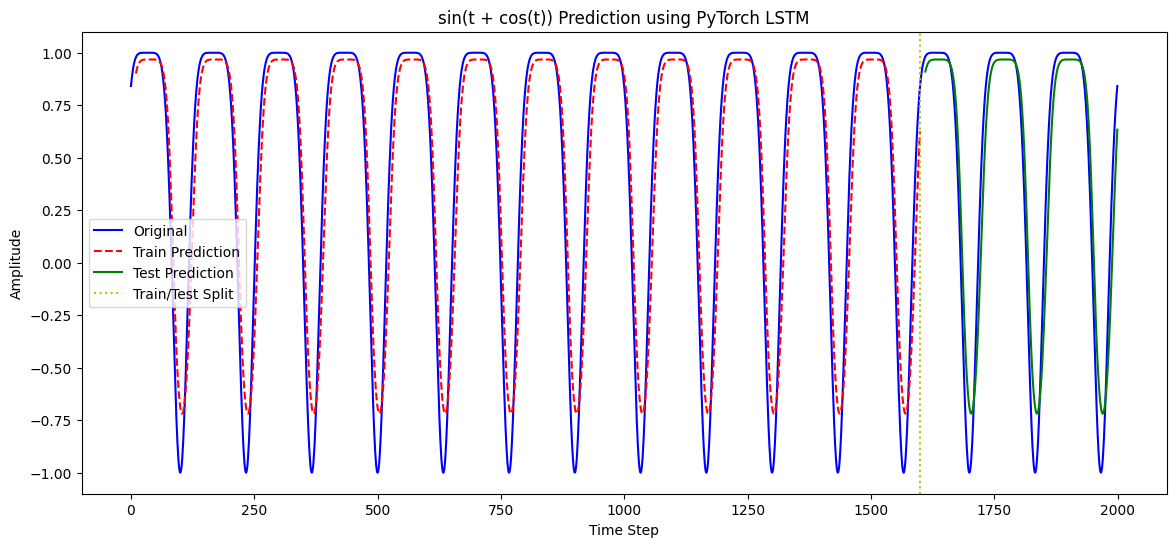

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# generate time series data, x = sin(t + cos(t))
def generate_time_series(start=0, end=30*np.pi, num_points=2000):
    t = torch.linspace(start, end, num_points)
    x = torch.sin(t + torch.cos(t))
    x = x.reshape(x.size(0), 1)
    return x

time_series = generate_time_series()

# split into train/test sets
train_ratio = 0.8
train_size = int(len(time_series) * train_ratio)
train_data = time_series[:train_size]
test_data = time_series[train_size:]

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, states_h_c = self.lstm(x)
        return self.linear(lstm_out[:, -1, :])

model = LSTMModel()
print(model)

# prepare train/test data for model
def create_sequences(data, seq_length):
    X_list, Y_list = [], []
    num_samples = len(data) - seq_length
    for i in range(num_samples):
        input_sequence = data[i:(i+seq_length), 0]
        X_list.append(input_sequence)
        target_point = data[i + seq_length, 0:1]
        Y_list.append(target_point)
    X_tensor = torch.stack(X_list)
    Y_tensor = torch.stack(Y_list)

    X_tensor = X_tensor.view(X_tensor.shape[0], X_tensor.shape[1], 1)
    return X_tensor, Y_tensor

seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing data shape: X={X_test.shape}, y={y_test.shape}")

# model training
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\nTraining LSTM model ...")

epochs = 80
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# evaluation
model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)

train_rmse = torch.sqrt(torch.mean((train_pred - y_train) ** 2)).item()
test_rmse = torch.sqrt(torch.mean((test_pred - y_test) ** 2)).item()

print(f"\nTrain RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

ts_np = time_series.numpy()
train_pred_np = train_pred.numpy()
test_pred_np = test_pred.numpy()

train_plot = np.full_like(ts_np, np.nan)
train_plot[seq_length:seq_length + len(train_pred_np)] = train_pred_np

test_plot = np.full_like(ts_np, np.nan)
test_start = train_size + seq_length
test_plot[test_start:test_start + len(test_pred_np)] = test_pred_np

plt.figure(figsize=(14, 6))
plt.plot(ts_np, label="Original", color="b")
plt.plot(train_plot, label="Train Prediction", linestyle="--", color="r")
plt.plot(test_plot, label="Test Prediction", color="g")
plt.axvline(x=train_size, color="y", linestyle=":", label="Train/Test Split")
plt.title("sin(t + cos(t)) Prediction using PyTorch LSTM")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.legend()
plt.show()